In [1]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import numpy as np
import time
import matplotlib.pyplot as plt
import glob
from PIL import Image
import random
import string
%matplotlib inline

In [2]:
MULTITHREADING_TITLE="Multithreading"
MULTIPROCESSING_TITLE="Multiprocessing"

def visualize_runtimes(results, title):
    start,stop = np.array(results).T
    plt.barh(range(len(start)),stop-start,left=start)
    plt.grid(axis='x')
    plt.ylabel("Tasks")
    plt.xlabel("Seconds")
    plt.title(title)
    return stop[-1]-start[0]

In [3]:
def multithreading(func, args, workers):
    begin_time = time.time()
    with ThreadPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)
        
def multiprocessing(func, args, workers):
    begin_time = time.time()
    with ProcessPoolExecutor(max_workers=workers) as executor:
        res = executor.map(func, args, [begin_time for i in range(len(args))])
    return list(res)

# API Calls

In [4]:
from urllib.request import urlopen

def download(url, base):
    start = time.time() - base
    try:
        resp = urlopen(url)
    except Exception as e:
        print ('ERROR: %s' % e)
    stop = time.time() - base
    return start,stop

In [5]:
N = 16
URL = 'http://scholar.princeton.edu/sites/default/files/oversize_pdf_test_0.pdf'
urls = [URL for i in range(N)]

#### Serial

In [6]:
%timeit -n 1 [download(url, 1) for url in urls]

6.57 s ± 230 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

6.922646522521973

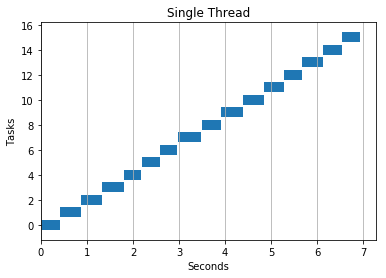

In [7]:
visualize_runtimes(multithreading(download, urls, 1), "Single Thread")

3.4661049842834473

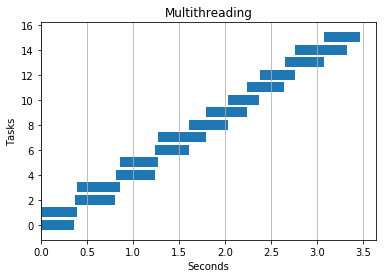

In [8]:
visualize_runtimes(multithreading(download, urls, 2),MULTITHREADING_TITLE)

2.6488351821899414

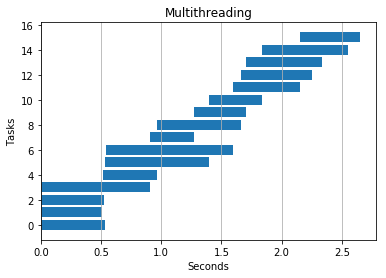

In [9]:
visualize_runtimes(multithreading(download, urls, 4),MULTITHREADING_TITLE)

#### Multiprocessing

6.671541690826416

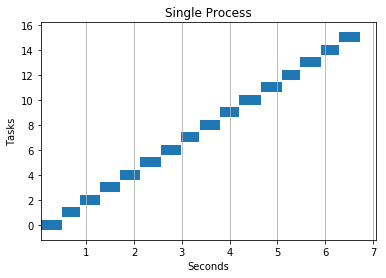

In [10]:
visualize_runtimes(multiprocessing(download, urls, 1), "Single Process")

3.5729753971099854

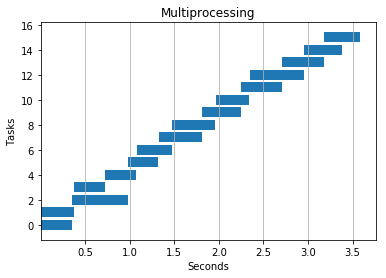

In [12]:
visualize_runtimes(multiprocessing(download, urls, 2), MULTIPROCESSING_TITLE)

2.533604860305786

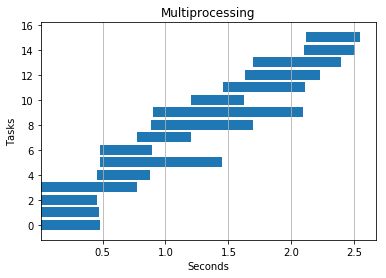

In [14]:
visualize_runtimes(multiprocessing(download, urls, 4), MULTIPROCESSING_TITLE)

# IO Heavy

In [15]:
def io_heavy(text,base):
    start = time.time() - base
    f = open('output.txt', 'wt', encoding='utf-8')
    f.write(text)
    f.close()
    stop = time.time() - base
    return start,stop

In [16]:
N=12
TEXT = ''.join(random.choice(string.ascii_lowercase) for i in range(10**7*5))

#### Serial

In [17]:
%timeit -n 1 [io_heavy(TEXT,1) for i in range(N)]

4.1 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Should see good benefit from this

3.830061197280884

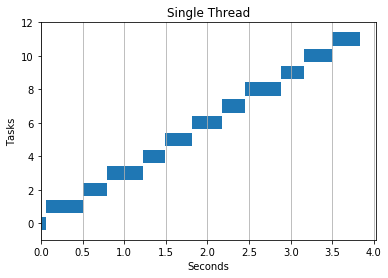

In [18]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 1),"Single Thread")

2.0366458892822266

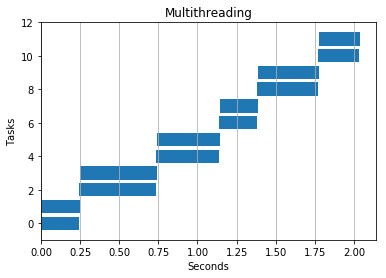

In [19]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 2),MULTITHREADING_TITLE)

1.361510992050171

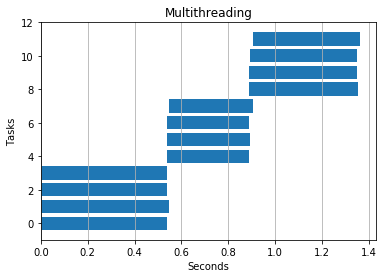

In [20]:
visualize_runtimes(multithreading(io_heavy, [TEXT for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Should see good benefit from this

3.836853504180908

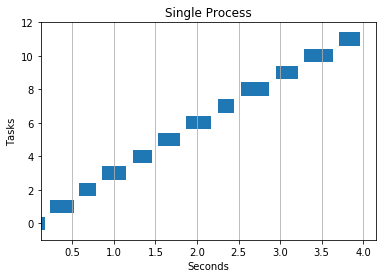

In [21]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 1),"Single Process")

2.0420429706573486

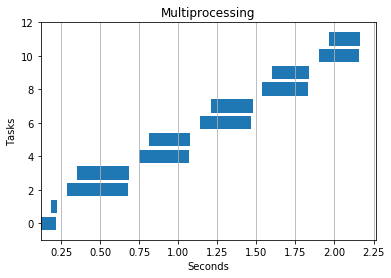

In [22]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 2),MULTIPROCESSING_TITLE)

1.2316887378692627

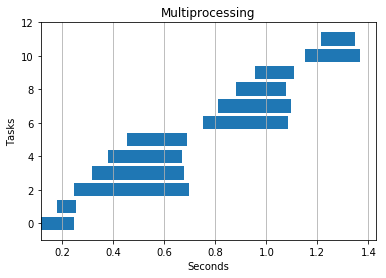

In [23]:
visualize_runtimes(multiprocessing(io_heavy, [TEXT for i in range(N)], 4),MULTIPROCESSING_TITLE)

# Numpy Functions

### Numpy Addition

In [24]:
#Does not use parallel processing by default
#But will see speedups if multiprocessing used
#Because numpy sidesteps python's GIL
def addition(i, base):
    start = time.time() - base
    res = a + b
    stop = time.time() - base
    return start,stop

In [25]:
DIMS = 20000
N = 20
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [26]:
%timeit -n 1 [addition(i, time.time()) for i in range(N)]

21.3 s ± 174 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

23.415029525756836

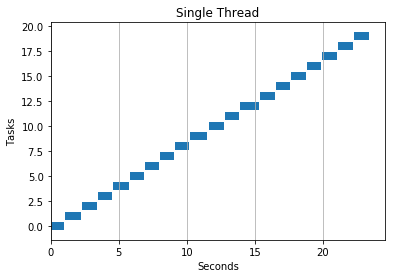

In [27]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 1),"Single Thread")

15.6945161819458

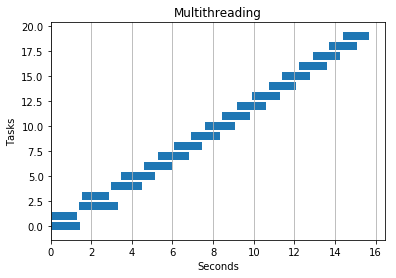

In [28]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 2),MULTITHREADING_TITLE)

11.406994819641113

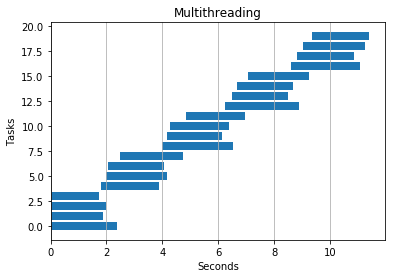

In [29]:
visualize_runtimes(multithreading(addition, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Some benefit for numpy addition (operation avoids GIL, but not parallel by default)

23.22743821144104

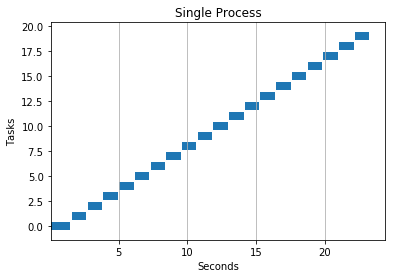

In [30]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 1),"Single Process")

In [ ]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)

In [ ]:
visualize_runtimes(multiprocessing(addition, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)

### Dot Product

In [33]:
#Automatic parallel processing built works out of the box
#Depending on BLAS impl, MKL (default with anaconda3) does
#Should NOT see speedups with multithreading/processing
def dot_product(i, base):
    start = time.time() - base
    res = np.dot(a,b)
    stop = time.time() - base
    return start,stop

DIMS = 3000
N = 10
DIMS_ARR = [DIMS for i in range(N)]
a = np.random.rand(DIMS,DIMS)
b = np.random.rand(DIMS,DIMS)

#### Serial

In [34]:
%timeit -n 1 [dot_product(i, time.time()) for i in range(N)]

5.74 s ± 249 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on dot product (since already parallel)

6.282103061676025

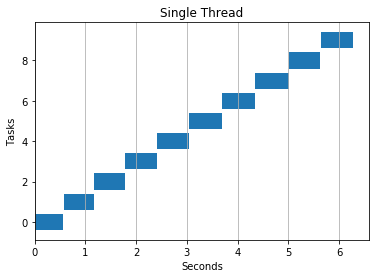

In [35]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 1),"Single Thread")

5.957345724105835

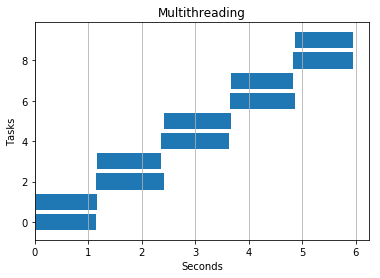

In [36]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 2),MULTITHREADING_TITLE)

6.106561660766602

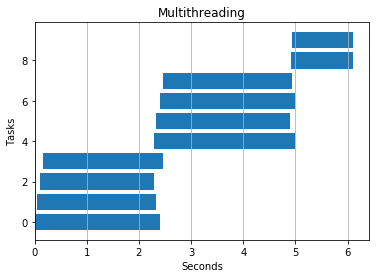

In [37]:
visualize_runtimes(multithreading(dot_product, [i for i in range(N)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

No benefit on dot product (since already parallel)

6.240516424179077

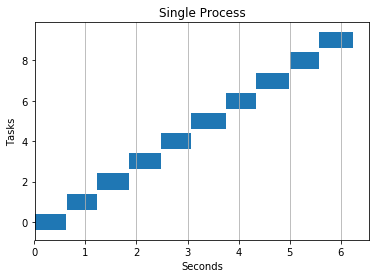

In [38]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 1),"Single Process")

5.289156913757324

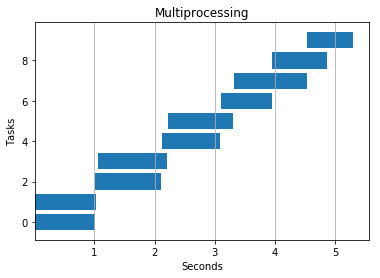

In [39]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 2),MULTIPROCESSING_TITLE)

4.984158277511597

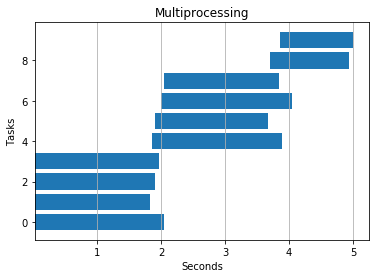

In [40]:
visualize_runtimes(multiprocessing(dot_product, [i for i in range(N)], 4),MULTIPROCESSING_TITLE)

### CPU Intensive

In [41]:
def cpu_heavy(n,base):
    start = time.time() - base
    count = 0
    for i in range(n):
        count += i
    stop = time.time() - base
    return start,stop

In [42]:
N = 10**7
ITERS = 10

#### Serial

In [43]:
%timeit -n 1 [cpu_heavy(N, time.time()) for i in range(ITERS)]

3.98 s ± 50.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Multithreading

No benefit on CPU-intensive tasks

4.03224778175354

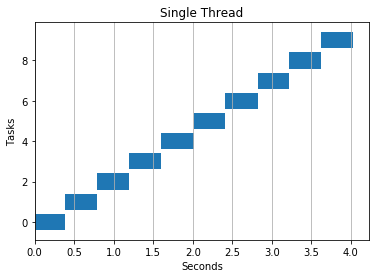

In [44]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 1),"Single Thread")

3.970308303833008

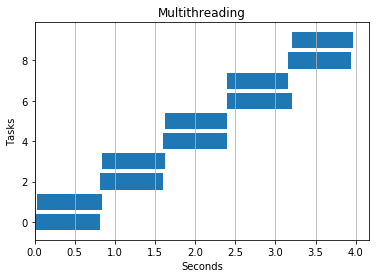

In [45]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 2),MULTITHREADING_TITLE)

3.9123692512512207

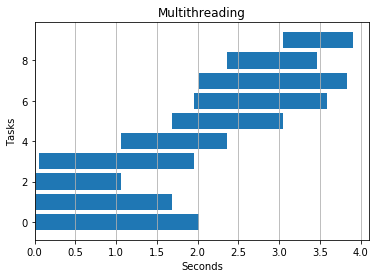

In [46]:
visualize_runtimes(multithreading(cpu_heavy, [N for i in range(ITERS)], 4),MULTITHREADING_TITLE)

#### Multiprocessing

Shows benefits on CPU-intensive tasks

4.076059579849243

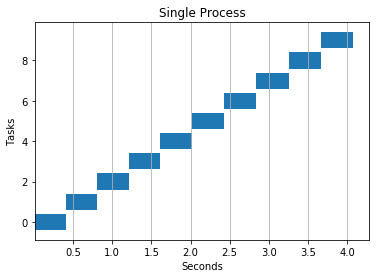

In [47]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 1),"Single Process")

1.9234423637390137

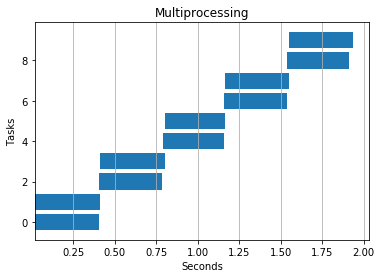

In [48]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 2),MULTIPROCESSING_TITLE)

1.1801116466522217

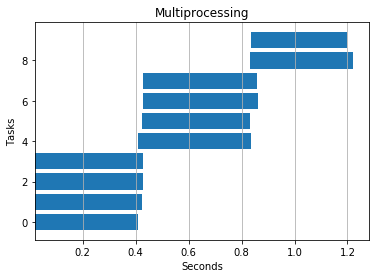

In [49]:
visualize_runtimes(multiprocessing(cpu_heavy, [N for i in range(ITERS)], 4),MULTIPROCESSING_TITLE)